In [1]:
# pretrained model: Hazır model (önceden -genellikle- başkaları tarafından eğitilmiş model)
# VGG16: https://www.mygreatlearning.com/blog/introduction-to-vgg16/

In [1]:
# ! Google Colab kullanıyorsanız, Runtime->Change runtime->GPU
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape = (180, 180, 3)
)

58900480/58889256 [==============================] - 1s 0us/step


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:11<00:00, 66.5MB/s]
100% 812M/812M [00:11<00:00, 71.7MB/s]


In [6]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [7]:
!unzip --qq dogs-vs-cats.zip

In [8]:
!unzip --qq train.zip

In [9]:
# Resim dosyalarının ayrılması (train,validation,test)
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs")

In [10]:
def make_subset(subset_name,start_index,end_index):
  for category in ("cat","dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname) 

In [11]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [12]:
!ls cats_vs_dogs

test  train  validation


In [13]:
# Resim dosyalarını oku ve dataset olarak kullan
from tensorflow.keras.utils import image_dataset_from_directory

In [14]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", 
    image_size=(180,180), 
    batch_size=32)

validataion_dataset = image_dataset_from_directory(
    new_base_dir / "validation", 
    image_size=(180,180), 
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", 
    image_size=(180,180), 
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [15]:
# VGG16
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [16]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validataion_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [17]:
train_features.shape

(2000, 5, 5, 512)

In [18]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [19]:
model.compile(loss = "binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [20]:
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath = "feature_extraction.keras",
                 save_best_only=True,
                 monitor="val_loss"
             )
]

In [21]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data = (val_features, val_labels),
    callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 21.8650 - accuracy: 0.9180 - val_loss: 4.4068 - val_accuracy: 0.9630
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.4533 - accuracy: 0.9750 - val_loss: 5.2298 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2.4353 - accuracy: 0.9840 - val_loss: 4.1526 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.3859 - accuracy: 0.9925 - val_loss: 5.3700 - val_accuracy: 0.9670
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.7287 - accuracy: 0.9925 - val_loss: 3.5970 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2940 - accuracy: 0.9905 - val_loss: 6.9785 - val_accuracy: 0.9610
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.4011 - accuracy: 0.9960 - val_loss: 6.8173 - val_accuracy: 0.9740
Epoch 8/20
63/63 [

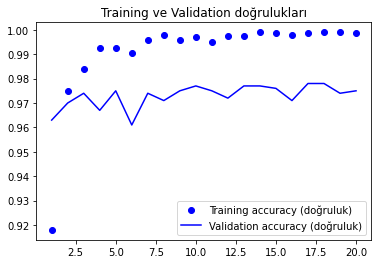

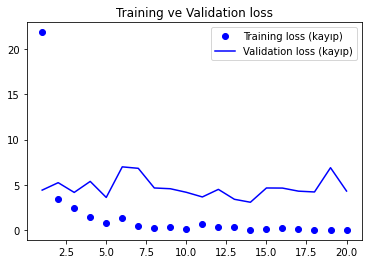

In [22]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, "bo", label="Training accuracy (doğruluk)")
plt.plot(epochs, val_acc, "b", label="Validation accuracy (doğruluk)")
plt.title("Training ve Validation doğrulukları")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss (kayıp)")
plt.plot(epochs, val_loss, "b", label="Validation loss (kayıp)")
plt.title("Training ve Validation loss")
plt.legend()
plt.show()


In [23]:
# Data augmentation ve paramterer tuning ile model performansı daha da iyileştirilebilir. % 97 => % 99

**Zaman serisi tahminleri**

In [24]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-05-20 06:47:00--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.136.120
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.136.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.45MB/s    in 2.4s    

2022-05-20 06:47:03 (5.45 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [25]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [26]:
!ls

cats_vs_dogs			__MACOSX
dogs-vs-cats.zip		sample_data
feature_extraction.keras	sampleSubmission.csv
jena_climate_2009_2016.csv	test1.zip
jena_climate_2009_2016.csv.zip	train
kaggle.json			train.zip


In [30]:
import os
dosya_ad = os.path.join("jena_climate_2009_2016.csv")

with(open(dosya_ad)) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

In [31]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [32]:
import numpy as np 
temperature = np.zeros((len(lines)))
raw_data = np.zeros((len(lines), len(header) - 1))
for  i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:] 

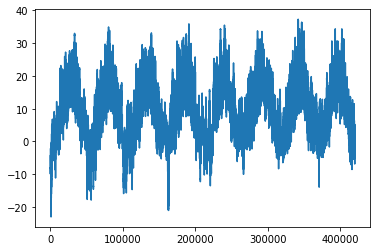

In [33]:
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)),temperature)

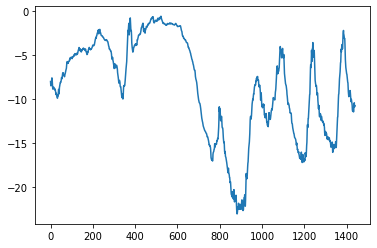

In [34]:
plt.plot(range(1440),temperature[:1440]) # 10 dakikalık bir veri, bir günde 144, 10 günde 1440 veri

In [35]:
# Eğitim, doğrulama, ve test verisetleri
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [36]:
print(f"eğitim verisi: {num_train_samples}")
print(f"validasyon verisi: {num_val_samples}")
print(f"test verisi: {num_test_samples}")

eğitim verisi: 210225
validasyon verisi: 105112
test verisi: 105114


In [37]:
# Normalizasyon işlemi (ortalama=>0, standart sapması=>1) 
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data = raw_data - mean 

In [38]:
std = raw_data[:num_train_samples].std(axis=0)
raw_data = raw_data / std

In [39]:
raw_data[:num_train_samples].mean(axis=0)

array([ 2.41475380e-12, -3.05637850e-15,  6.68780780e-13, -1.42886289e-14,
        3.51971409e-15,  5.10501302e-15, -1.94199588e-14, -1.59385870e-14,
        3.70925404e-14,  3.44193167e-15, -2.11755148e-13,  1.80338307e-14,
       -5.53960641e-14, -2.12645486e-15])

In [40]:
raw_data[:num_train_samples].std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [47]:
sampling_rate = 6 # 1 saatte yapılan gözlem sayısı, 10 dakikalık veri => saatte 6 tane ölçüm => sampling_rate=6
sequence_length = 120 # Gözlemler geçmişteki 120 saate => 5 gün
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256


In [48]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples + num_val_samples
)


In [56]:
for samples, targets in train_dataset:
  print(samples.shape)
  print(targets.shape)
  break

(256, 120, 14)
(256,)


In [57]:
# Modelin başarılı olarak kabul edilmesi için performansı ne olmalı?
def evaluate_naive_method(dataset):
  toplam_mutlak_hata = 0.
  samples_seen = 0
  for samples, targets in dataset: 
    tahminler = samples[:, -1, 1] * std[1] + mean[1] # un-normalize (normalizasyon öncesi ilk değere dönüşüm)
    toplam_mutlak_hata += np.sum(np.abs(tahminler - targets))
    samples_seen += samples.shape[0]
  return toplam_mutlak_hata / samples_seen


In [58]:
val_dataset_naive_mae = evaluate_naive_method(val_dataset)
test_dataset_naive_mae = evaluate_naive_method(test_dataset)

In [59]:
print(f"Naive method MAE (validation dataset)={val_dataset_naive_mae}")
print(f"Naive method MAE (test dataset)={test_dataset_naive_mae}")

Naive method MAE (validation dataset)=2.4417357485655176
Naive method MAE (test dataset)=2.6218984517612074


In [62]:
# Basit bir model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset,
    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 41s 49ms/step - loss: 12.7986 - mae: 2.7628 - val_loss: 11.6106 - val_mae: 2.6927
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 9.2432 - mae: 2.3886 - val_loss: 12.5082 - val_mae: 2.8037
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 8.4736 - mae: 2.2889 - val_loss: 10.6452 - val_mae: 2.5911
Epoch 4/10
819/819 [==============================] - 41s 49ms/step - loss: 8.0413 - mae: 2.2313 - val_loss: 10.6323 - val_mae: 2.5831
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 7.6203 - mae: 2.1742 - val_loss: 11.1310 - val_mae: 2.6481
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 7.3353 - mae: 2.1337 - val_loss: 12.0682 - val_mae: 2.7655
Epoch 7/10
204/819 [======>.......................] - ETA: 20s - loss: 7.1784 - mae: 2.1098

KeyboardInterrupt: ignored

In [63]:
# RNN: Recurrent Neutral Networks
# https://en.wikipedia.org/wiki/Recurrent_neural_network

In [64]:
# LSTM: Long Short Term Memory yaygın olarak kullanılır. (RNN temelli)

In [65]:
# RNN-LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs) # !! LSTM model
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 48s 55ms/step - loss: 39.8609 - mae: 4.5997 - val_loss: 12.3027 - val_mae: 2.6584
Epoch 2/10
819/819 [==============================] - 46s 55ms/step - loss: 10.9220 - mae: 2.5769 - val_loss: 10.0276 - val_mae: 2.4465
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 10.0594 - mae: 2.4759 - val_loss: 9.9060 - val_mae: 2.4268
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.7668 - mae: 2.4377 - val_loss: 9.6974 - val_mae: 2.3969
Epoch 5/10
810/819 [============================>.] - ETA: 0s - loss: 9.4694 - mae: 2.3997

KeyboardInterrupt: ignored

In [66]:
# RNN-LSTM model - DROPOUT ile
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # !! LSTM model
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset, 
    epochs=50, 
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
639/819 [======================>.......] - ETA: 1:10 - loss: 31.2272 - mae: 4.1222

KeyboardInterrupt: ignored